In [31]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input, MultiHeadAttention, Dropout, Concatenate
import tensorflow_addons as tfa  # thư viện cho Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Input, Attention,concatenate
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [32]:
data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\train_data2.csv') 
data.set_index('Ngay', inplace=True)

In [33]:
# Chuẩn hóa dữ liệu để đưa về khoảng [0, 1] để dễ xử lý khi đưa vào mô hình
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [34]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])  # 'mucNuocHN' là cột đầu tiên
    return np.array(sequences), np.array(targets)

In [35]:
sequence_length = 3 # Sử dụng số ngày trước để dự báo ngày tiếp theo
X, y = create_sequences(data_scaled, sequence_length)

In [36]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [37]:
# Thay đổi hình dạng dữ liệu đầu vào cho LSTM (số mẫu, bước thời gian, số đặc trưng)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [38]:
input_layer = Input(shape=(sequence_length, X_train.shape[2]))

In [39]:
# LSTM lớp ẩn
lstm_out = LSTM(64, return_sequences=True)(input_layer)

# Lớp Attention
attention = MultiHeadAttention(num_heads=4, key_dim=64)(lstm_out, lstm_out)
concat_output = Concatenate()([lstm_out, attention])
dropout_layer = Dropout(0.1)(concat_output)
attention_output = tf.reduce_sum(dropout_layer, axis=1)

# Lớp đầu ra
output = Dense(1)(attention_output)

In [40]:
# Khởi tạo và biên dịch mô hình
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 3, 7)]               0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 3, 64)                18432     ['input_2[0][0]']             
                                                                                                  
 multi_head_attention_1 (Mu  (None, 3, 64)                66368     ['lstm_1[0][0]',              
 ltiHeadAttention)                                                   'lstm_1[0][0]']              
                                                                                                  
 concatenate_1 (Concatenate  (None, 3, 128)               0         ['lstm_1[0][0]',        

In [41]:
# 3. Huấn luyện mô hình
history = model.fit(X_train,y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


64/64 [==============================] - 5s 20ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 2/50
64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 3/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/50
64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 6/50
64/64 [==============================] - 1s 15ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 7/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 8/50
64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/50
64/64 [==============================] - 1s 15ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/50
64/64 [==============================] - 1s 17ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 11/50
64/64 [=

In [42]:
def nse(y_true, y_pred):
    return 1 - sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2)

In [43]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R² (R-squared):", r2)

# Tính NSE
nse_value = nse(y_test.flatten(), y_pred.flatten())
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

# Tính MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

16/16 [==============================] - 1s 6ms/step
R² (R-squared): 0.974991745301087
Nash-Sutcliffe Efficiency (NSE): 0.9749917453010869
Mean Absolute Error (MAE): 0.013278221643565003
Root Mean Squared Error (RMSE): 0.019297606447745967


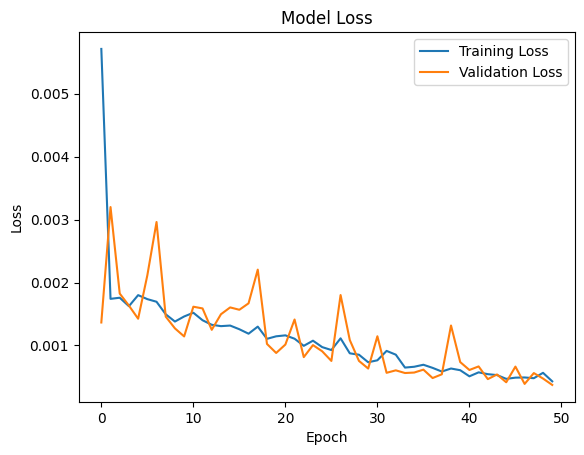

In [44]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
# 5. Vẽ đồ thị dự báo so sánh với thực tế cho từng mực nước
new_data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\test_data2_1.csv') 
new_data['Ngay'] = pd.to_datetime(new_data['Ngay'], format='%d/%m/%Y')
new_data.set_index('Ngay', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(new_data)

In [46]:
# Chuẩn hóa dữ liệu mới
new_data_scaled = scaler.transform(new_data)  # Sử dụng scaler đã huấn luyện từ dữ liệu ban đầu

# Chia dữ liệu mới thành chuỗi thời gian
X_test_new, y_test_new = create_sequences(new_data_scaled, sequence_length)
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], X_test_new.shape[2]))

In [47]:
predictions_new = model.predict(X_test_new)
num_columns = new_data_scaled.shape[1]
print(num_columns)
predictions_new_original = scaler.inverse_transform(
    np.concatenate((predictions_new, np.zeros((predictions_new.shape[0], num_columns - predictions_new.shape[1]))), axis=1)
)[:, 0]

# Thêm đủ các cột phụ vào y_test_new để khớp với số cột của scaler
y_test_new_original = scaler.inverse_transform(
    np.concatenate((y_test_new.reshape(-1, 1), np.zeros((y_test_new.shape[0], num_columns - 1))), axis=1)
)[:, 0]


23/23 [==============================] - 0s 6ms/step
7


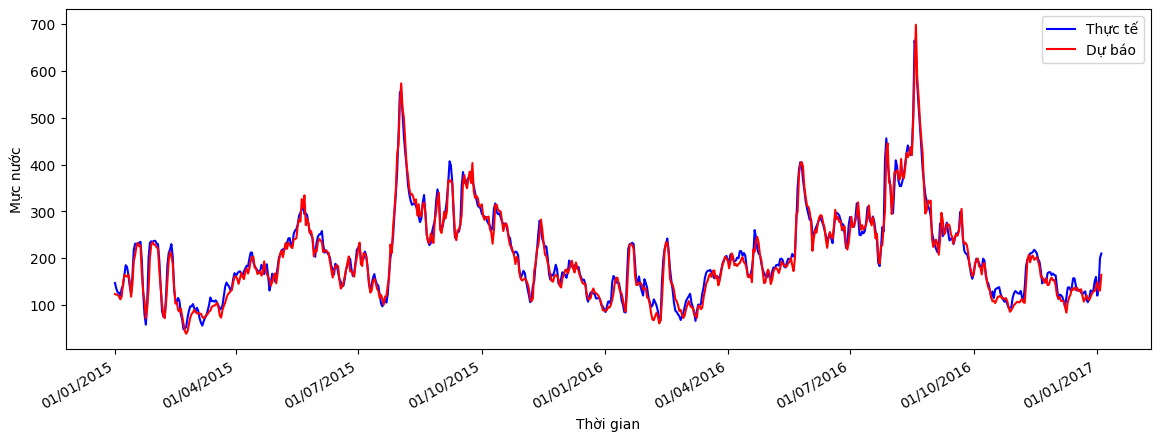

In [48]:
# Đảm bảo các mảng có cùng kích thước
import matplotlib.dates as mdates 
min_length = min(len(new_data.index), len(y_test_new_original), len(predictions_new_original))

# Cắt ngắn mảng theo độ dài nhỏ nhất
dates = new_data.index[:min_length]
y_test_new_original = y_test_new_original[:min_length]
predictions_new_original = predictions_new_original[:min_length]

# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_new_original, label='Thực tế', color='blue')
plt.plot(dates, predictions_new_original, label='Dự báo', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước')

# Định dạng ngày tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()
